In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/AE")
sys.path.append("/data/tim/heronWorkspace/classifier")
sys.path.append("/data/tim/heronWorkspace/")


from AEHeronModelV1 import AEHeronModel
from AEHeronModelV2 import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from MLPV1 import MLP, MLPMSEHeatMap
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive, UnNormalize
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform, uniform
import functorch
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
# from torchmetrics import ConfusionMatrix

sns.set_theme()




# Params:
- different CAE
- cameraProps - cutoff on the sides
- gaussian filter params / min-filter params
- zero thresholds
- sum threshold
- dataset props

In [9]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)

distributions = dict(
    cameras = [["NEN1", "SBU3"]],
    balanced = [True, False],
    distinctCAETraining = [True, False],
    gaussianFilterSize = [5],
    gaussianFilterSigma = [1, 3, 5, 7],
    filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
    zeroThreshold = uniform(0.2, 0.4), # loguniform(0.15, 0.4), #threshold for zeroing out the image
    sumThreshold = uniform(1.5, 50),
    lossFn = ["L1"]#["MSE", "L1"],
)

sampler = ParameterSampler(distributions, n_iter=30, random_state=loaderParams["random_state"])

includeCameraProps = False
model = CAEV1

checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
caeLoaded.freeze()
print(caeLoaded.hparams)

fileName = "basicCAETest"
columns = ["trueLbl", "predictedLbl", "ImagePath", "includeCameraProps", "CAECheckPoint", "isCAETrainingCamera"] + list(loaderParams.keys()) + list(distributions.keys()) 
try:
    df = pd.read_csv(f"/data/tim/heronWorkspace/caeTestData/{fileName}.csv")
except:
    df = pd.DataFrame(columns=columns)


"batch_size":         16
"bottleneck":         128
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.7879353477950641
"ldim":               16
"learning_rate":      0.003533238255084643
"num_workers_loader": 4
"transforms":         None
"weight_decay":       4.5387898639621974e-07


In [2]:
def min_filter(tensor : torch.Tensor, kernel_size=3):
    # Unfold the tensor into sliding local blocks
    unfolded = tensor.unfold(0, kernel_size, 1)
    unfolded = unfolded.unfold(1, kernel_size, 1)
    # Compute the minimum in each of these blocks
    return unfolded.min(dim=-1)[0].min(dim=-1)[0]

In [36]:
a = torch.tensor([[[0] * 5, [1] * 5, [2] * 5, [3] * 5, [4] * 5]]).unfold(1, 3, 1)
a.unfold(2, 3, 1)

a = torch.tensor([[0] * 5, [1] * 5, [2] * 5, [3] * 5, [4] * 5]).unfold(0, 3, 1)
a.unfold(1, 3, 1).shape

torch.Size([3, 3, 3, 3])

try: unnorm only on result

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 1, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 48.12786796693294, 'zeroThreshold': 0.18203111198233918}


mean pos: 176.5253744992343, std pos: 132.75819054625288
mean neg: 108.22012641213156, std neg: 104.74634969747417
lowest pos: 19.28041648864746, highest pos: 489.6961669921875
lowest neg: 18.681110382080078, highest neg: 386.7702941894531
accuracy: 0.6363636363636364
precision: 0.5882352941176471
recall: 0.9090909090909091
f1: 0.7142857142857143


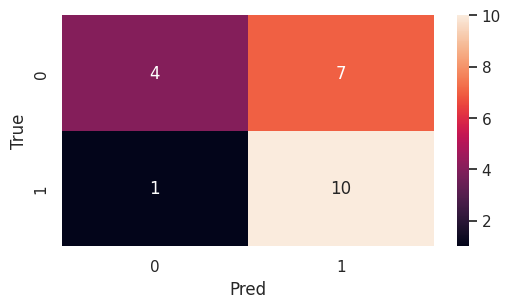

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 1, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 6.1169297384398895, 'zeroThreshold': 0.19656505284441772}
mean pos: 166.93556490811434, std pos: 129.52973529871718
mean neg: 96.21605387600985, std neg: 96.68623216058766
lowest pos: 17.57843780517578, highest pos: 480.58477783203125
lowest neg: 14.50820541381836, highest neg: 356.25616455078125
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


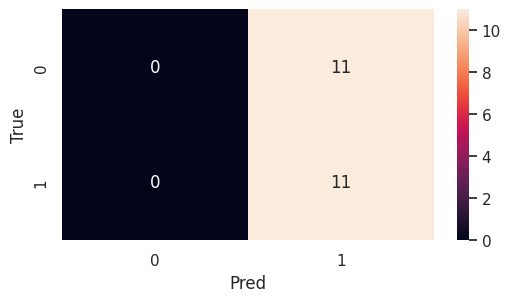

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 48.27695354030159, 'zeroThreshold': 0.36157772917150427}
mean pos: 104.95815229415894, std pos: 105.85609786617049
mean neg: 24.965775511481546, std neg: 32.07974692103845
lowest pos: 1.9937500953674316, highest pos: 403.49261474609375
lowest neg: 0.0, highest neg: 117.35692596435547
accuracy: 0.8181818181818182
precision: 0.8888888888888888
recall: 0.7272727272727273
f1: 0.7999999999999999


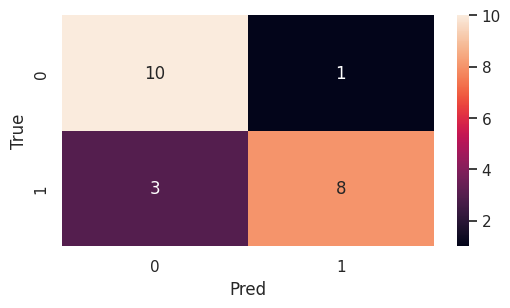

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 1, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 11.722612486575871, 'zeroThreshold': 0.3695293590977363}
mean pos: 102.93150368603793, std pos: 104.74494928894948
mean neg: 23.37051649527116, std neg: 30.37894338431933
lowest pos: 1.9937500953674316, highest pos: 399.47467041015625
lowest neg: 0.0, highest neg: 111.50825500488281
accuracy: 0.6818181818181818
precision: 0.625
recall: 0.9090909090909091
f1: 0.7407407407407406


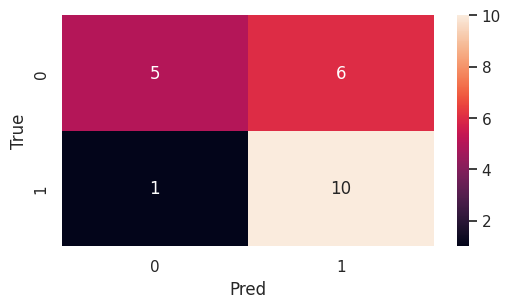

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 47.19810122896165, 'zeroThreshold': 0.26430120199674706}
mean pos: 132.74452504244718, std pos: 116.95818152412002
mean neg: 55.19536174427379, std neg: 62.26833753863021
lowest pos: 8.870183944702148, highest pos: 441.70947265625
lowest neg: 1.7279644012451172, highest neg: 226.02207946777344
accuracy: 0.6818181818181818
precision: 0.6666666666666666
recall: 0.7272727272727273
f1: 0.6956521739130435


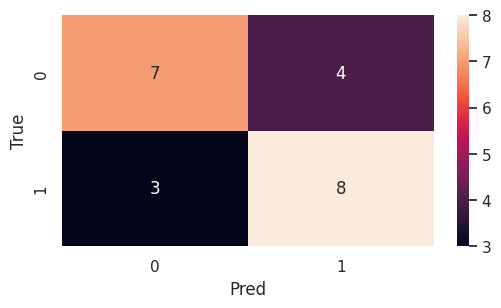

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 11.40507445424394, 'zeroThreshold': 0.35018614216888416}
mean pos: 108.0603177764199, std pos: 106.68997471825507
mean neg: 27.4250063625249, std neg: 35.700945428013284
lowest pos: 2.3552603721618652, highest pos: 406.6639099121094
lowest neg: 0.0, highest neg: 130.8802947998047
accuracy: 0.6363636363636364
precision: 0.5882352941176471
recall: 0.9090909090909091
f1: 0.7142857142857143


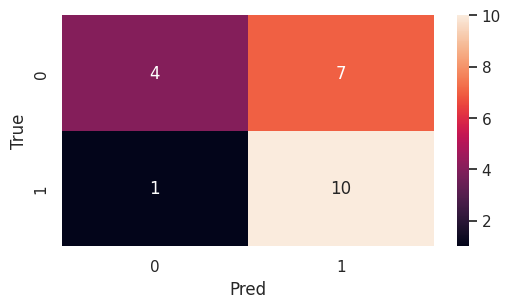

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 6.140040432036896, 'zeroThreshold': 0.2795381372354723}
mean pos: 127.16180684349753, std pos: 113.61935309810787
mean neg: 48.864281881939284, std neg: 56.161955851019705
lowest pos: 7.780394077301025, highest pos: 432.16448974609375
lowest neg: 1.4580503702163696, highest neg: 203.73348999023438
accuracy: 0.5909090909090909
precision: 0.55
recall: 1.0
f1: 0.7096774193548387


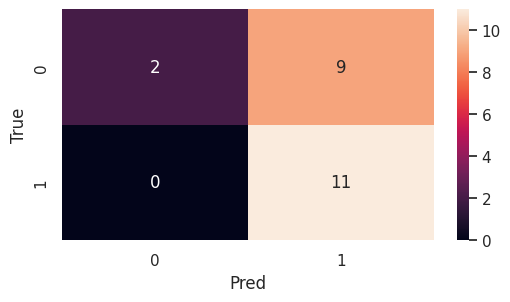

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 5.752210568488896, 'zeroThreshold': 0.15976369580822058}
mean pos: 195.37717004255816, std pos: 141.41656760190372
mean neg: 128.82651155645198, std neg: 118.67811095041873
lowest pos: 24.949392318725586, highest pos: 509.16656494140625
lowest neg: 28.851709365844727, highest neg: 439.27252197265625
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


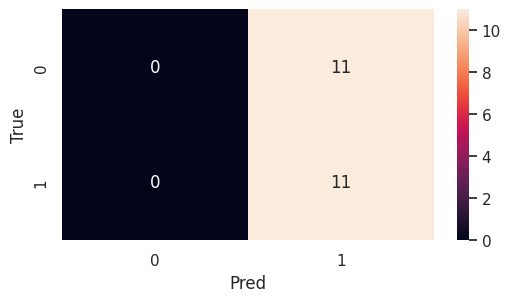

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 35.026402003447274, 'zeroThreshold': 0.2982663795745142}
mean pos: 121.61702433499423, std pos: 111.18412277112124
mean neg: 42.331762140447445, std neg: 50.08389461839804
lowest pos: 4.910913467407227, highest pos: 423.237548828125
lowest neg: 0.6080269813537598, highest neg: 182.06765747070312
accuracy: 0.6363636363636364
precision: 0.6153846153846154
recall: 0.7272727272727273
f1: 0.6666666666666667


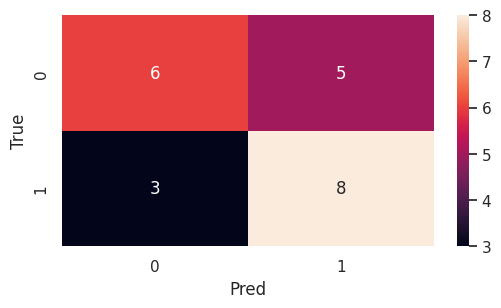

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 28.158264248650852, 'zeroThreshold': 0.32296927848761836}
mean pos: 115.38198568604209, std pos: 109.06140195569512
mean neg: 34.660774729468606, std neg: 42.28953229899522
lowest pos: 3.6594974994659424, highest pos: 416.091064453125
lowest neg: 0.0, highest neg: 154.72377014160156
accuracy: 0.6818181818181818
precision: 0.6428571428571429
recall: 0.8181818181818182
f1: 0.7200000000000001


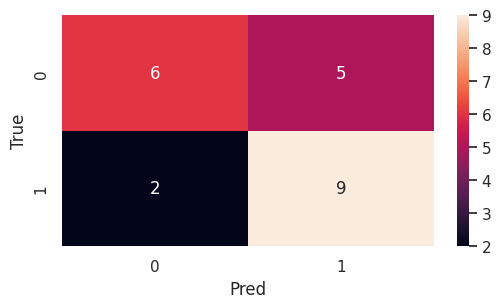

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 1, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 40.66572363474431, 'zeroThreshold': 0.2531347103757565}
mean pos: 137.8579046942971, std pos: 118.85117234042667
mean neg: 60.59392538937655, std neg: 66.91114574292538
lowest pos: 9.915291786193848, highest pos: 448.9534912109375
lowest neg: 2.2453413009643555, highest neg: 243.32601928710938
accuracy: 0.6818181818181818
precision: 0.6428571428571429
recall: 0.8181818181818182
f1: 0.7200000000000001


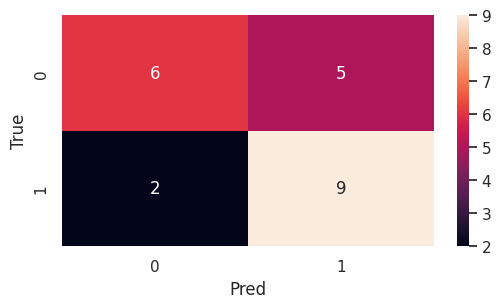

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 50.943054445324734, 'zeroThreshold': 0.33704141359495987}
mean pos: 110.84592450748791, std pos: 108.07989095119484
mean neg: 30.699048486622896, std neg: 38.74916535918014
lowest pos: 2.3552603721618652, highest pos: 412.1455993652344
lowest neg: 0.0, highest neg: 142.53524780273438
accuracy: 0.8181818181818182
precision: 0.8888888888888888
recall: 0.7272727272727273
f1: 0.7999999999999999


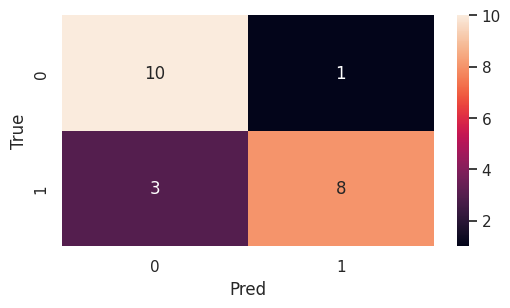

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 12.60622737676874, 'zeroThreshold': 0.1683410429356499}
mean pos: 187.62237930297852, std pos: 137.0430389047987
mean neg: 120.66148879311301, std neg: 112.70768779537238
lowest pos: 22.975116729736328, highest pos: 499.5337219238281
lowest neg: 24.601808547973633, highest neg: 416.18707275390625
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


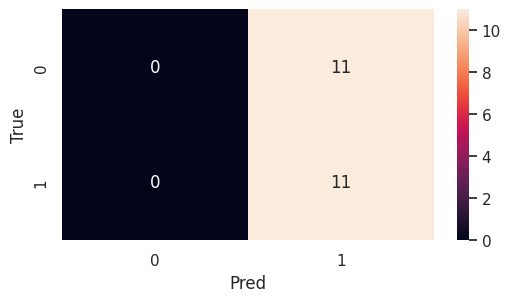

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 16.180707418683973, 'zeroThreshold': 0.22194383464658718}
mean pos: 152.5020115592263, std pos: 123.82459882829767
mean neg: 78.33903291008689, std neg: 83.65731962620171
lowest pos: 12.729673385620117, highest pos: 465.53662109375
lowest neg: 5.533270359039307, highest neg: 304.7713623046875
accuracy: 0.5454545454545454
precision: 0.5263157894736842
recall: 0.9090909090909091
f1: 0.6666666666666666


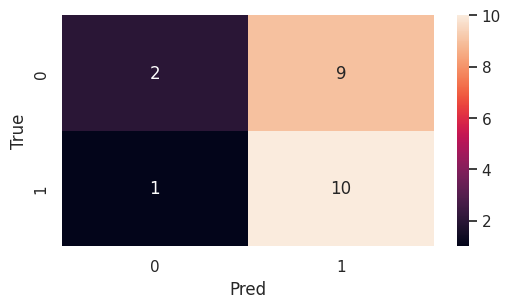

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 5.68115022735131, 'zeroThreshold': 0.3792153336324321}
mean pos: 99.76381050456654, std pos: 102.58340055979433
mean neg: 22.010289083827626, std neg: 28.649285844103858
lowest pos: 1.6163301467895508, highest pos: 390.85748291015625
lowest neg: 0.0, highest neg: 105.13816833496094
accuracy: 0.6363636363636364
precision: 0.5882352941176471
recall: 0.9090909090909091
f1: 0.7142857142857143


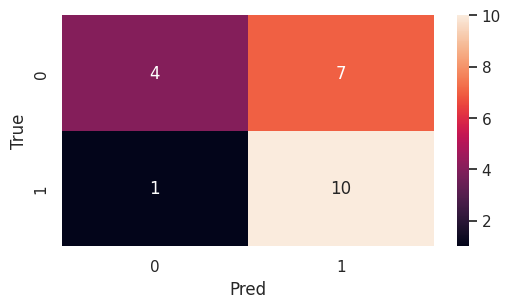

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 26.078657964016916, 'zeroThreshold': 0.1633406362792701}
mean pos: 191.6309448588978, std pos: 139.0233760053902
mean neg: 125.31765660372648, std neg: 116.18434374497495
lowest pos: 24.299585342407227, highest pos: 503.8326416015625
lowest neg: 26.759716033935547, highest neg: 429.1109619140625
accuracy: 0.45454545454545453
precision: 0.47619047619047616
recall: 0.9090909090909091
f1: 0.6249999999999999


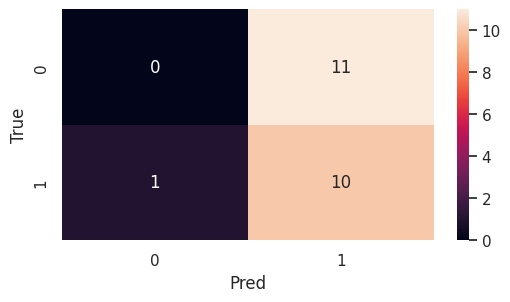

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 49.32678283352611, 'zeroThreshold': 0.2152447449038892}
mean pos: 156.53433869101784, std pos: 125.4422232082448
mean neg: 83.62833005731756, std neg: 87.94295204725279
lowest pos: 14.255792617797852, highest pos: 469.70269775390625
lowest neg: 8.162618637084961, highest neg: 322.04718017578125
accuracy: 0.6363636363636364
precision: 0.6
recall: 0.8181818181818182
f1: 0.6923076923076923


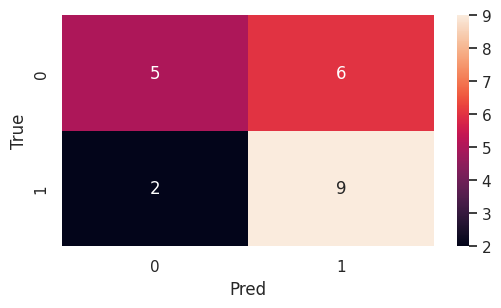

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 22.202799390978416, 'zeroThreshold': 0.32360003943193627}
mean pos: 115.2056863524697, std pos: 109.10500858199636
mean neg: 34.45508072592995, std neg: 42.13818649185147
lowest pos: 3.3364195823669434, highest pos: 416.091064453125
lowest neg: 0.0, highest neg: 154.07736206054688
accuracy: 0.7272727272727273
precision: 0.6666666666666666
recall: 0.9090909090909091
f1: 0.7692307692307692


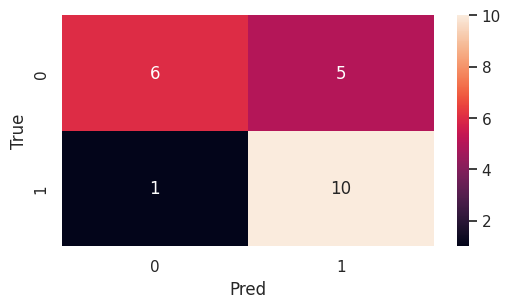

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 1, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 39.77425522204354, 'zeroThreshold': 0.1613364321436633}
mean pos: 193.80128184231845, std pos: 140.4548568391696
mean neg: 127.2651034268466, std neg: 117.47674428488214
lowest pos: 24.788084030151367, highest pos: 507.5623779296875
lowest neg: 27.406070709228516, highest neg: 433.978515625
accuracy: 0.6363636363636364
precision: 0.5882352941176471
recall: 0.9090909090909091
f1: 0.7142857142857143


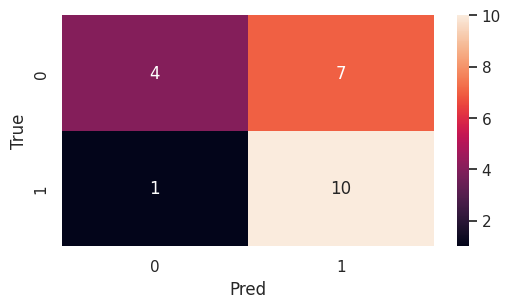

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 48.729737799540665, 'zeroThreshold': 0.2966387601254982}
mean pos: 121.99585012956099, std pos: 111.28663370751678
mean neg: 42.81830464709889, std neg: 50.310311699897554
lowest pos: 4.910913467407227, highest pos: 423.534423828125
lowest neg: 0.6080269813537598, highest neg: 182.66204833984375
accuracy: 0.7272727272727273
precision: 0.7272727272727273
recall: 0.7272727272727273
f1: 0.7272727272727273


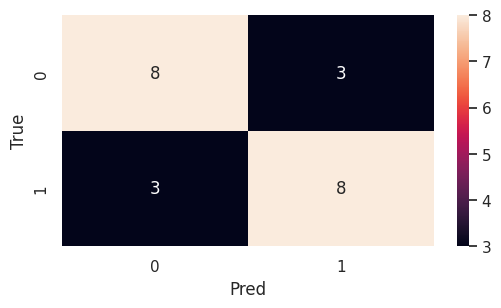

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 1, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 23.89900907102091, 'zeroThreshold': 0.3730339680004703}
mean pos: 102.08744070746683, std pos: 104.2555616851561
mean neg: 22.796840949492022, std neg: 29.74486211806096
lowest pos: 1.9937500953674316, highest pos: 397.2463073730469
lowest neg: 0.0, highest neg: 109.28182220458984
accuracy: 0.6818181818181818
precision: 0.6666666666666666
recall: 0.7272727272727273
f1: 0.6956521739130435


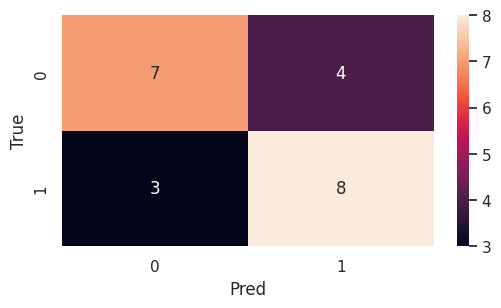

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 9.76770985584664, 'zeroThreshold': 0.3818771450990085}
mean pos: 99.10643449696627, std pos: 102.18590544770774
mean neg: 21.595591740174726, std neg: 28.085842771059514
lowest pos: 1.2357571125030518, highest pos: 389.7142639160156
lowest neg: 0.0, highest neg: 102.85807800292969
accuracy: 0.6818181818181818
precision: 0.625
recall: 0.9090909090909091
f1: 0.7407407407407406


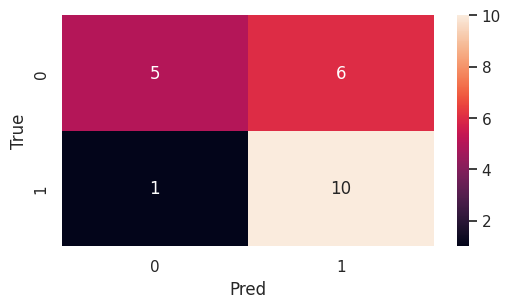

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 33.39182420298382, 'zeroThreshold': 0.18157872126122207}
mean pos: 176.9385660344904, std pos: 132.76392964018106
mean neg: 108.56716034629129, std neg: 104.90548739378988
lowest pos: 19.825843811035156, highest pos: 490.0596618652344
lowest neg: 18.681110382080078, highest neg: 387.49713134765625
accuracy: 0.6363636363636364
precision: 0.5882352941176471
recall: 0.9090909090909091
f1: 0.7142857142857143


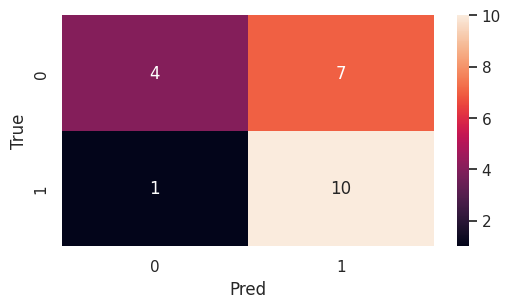

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 39.04712170136686, 'zeroThreshold': 0.23722458549446063}
mean pos: 144.70811895890668, std pos: 121.23564588913509
mean neg: 69.72853250937028, std neg: 75.7311955534067
lowest pos: 11.120748519897461, highest pos: 457.7530517578125
lowest neg: 3.709653615951538, highest neg: 275.346923828125
accuracy: 0.6818181818181818
precision: 0.625
recall: 0.9090909090909091
f1: 0.7407407407407406


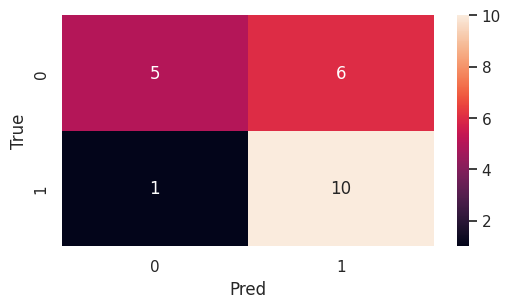

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 1, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 39.13941765878021, 'zeroThreshold': 0.37033545740850277}
mean pos: 102.76336986368352, std pos: 104.64870329355944
mean neg: 23.202336463061247, std neg: 30.088691997206862
lowest pos: 1.9937500953674316, highest pos: 399.1046142578125
lowest neg: 0.0, highest neg: 110.39822387695312
accuracy: 0.8181818181818182
precision: 0.8888888888888888
recall: 0.7272727272727273
f1: 0.7999999999999999


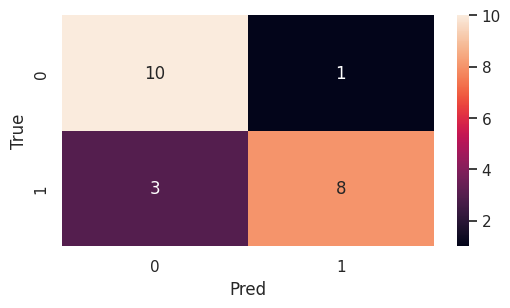

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 32.584786010456085, 'zeroThreshold': 0.1786864932383438}
mean pos: 179.39239571311256, std pos: 133.8200123971961
mean neg: 111.12161948464133, std neg: 106.63486167421114
lowest pos: 20.550071716308594, highest pos: 492.75616455078125
lowest neg: 19.937969207763672, highest neg: 393.97698974609375
accuracy: 0.5909090909090909
precision: 0.5555555555555556
recall: 0.9090909090909091
f1: 0.6896551724137931


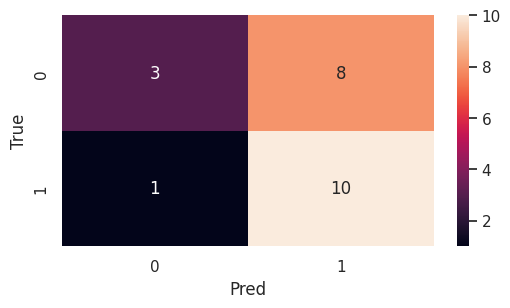

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 19.265518120821415, 'zeroThreshold': 0.3854592371883556}
mean pos: 98.44329255277461, std pos: 102.06539344567919
mean neg: 20.933008302341808, std neg: 27.26732209389576
lowest pos: 1.2357571125030518, highest pos: 389.32940673828125
lowest neg: 0.0, highest neg: 100.17378234863281
accuracy: 0.7727272727272727
precision: 0.7142857142857143
recall: 0.9090909090909091
f1: 0.8


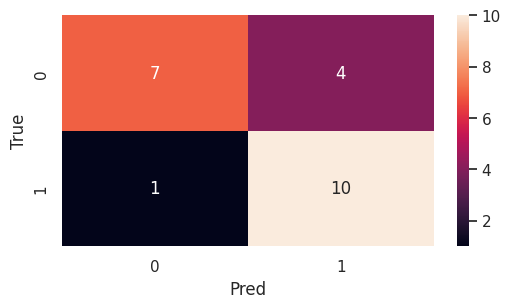

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 46.66897602811269, 'zeroThreshold': 0.2934198716680715}
mean pos: 122.82812630046497, std pos: 111.64751699648039
mean neg: 43.86469515887174, std neg: 51.64173625782681
lowest pos: 5.207415580749512, highest pos: 424.42010498046875
lowest neg: 0.6080269813537598, highest neg: 187.38648986816406
accuracy: 0.7272727272727273
precision: 0.7272727272727273
recall: 0.7272727272727273
f1: 0.7272727272727273


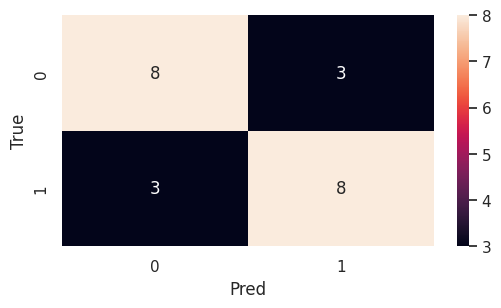

Length of dataset: 22
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 9.146491127701438, 'zeroThreshold': 0.2946584826839307}
mean pos: 122.61422725157304, std pos: 111.59655635790871
mean neg: 43.51701801473444, std neg: 51.28227505910315
lowest pos: 5.20741605758667, highest pos: 424.42010498046875
lowest neg: 0.6080269813537598, highest neg: 186.21011352539062
accuracy: 0.6363636363636364
precision: 0.5882352941176471
recall: 0.9090909090909091
f1: 0.7142857142857143


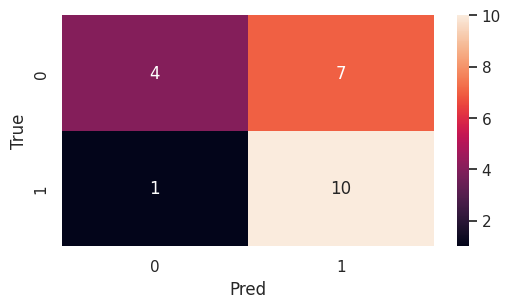

Length of dataset: 22
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 19.36348800012499, 'zeroThreshold': 0.37713378772994977}
mean pos: 100.38293062556873, std pos: 102.8591050243654
mean neg: 22.319526607340034, std neg: 29.256443359273188
lowest pos: 1.9937500953674316, highest pos: 391.993408203125
lowest neg: 0.0, highest neg: 107.40534973144531
accuracy: 0.7727272727272727
precision: 0.7142857142857143
recall: 0.9090909090909091
f1: 0.8


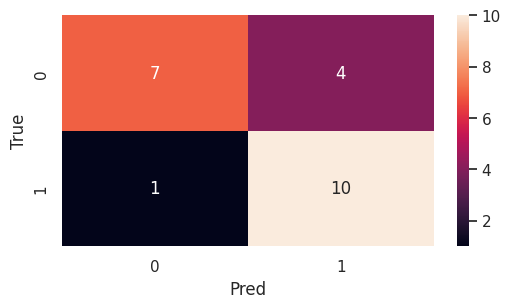

In [10]:
#TODO: include camerProps

# confMat = ConfusionMatrix(task="binary", num_classes=2)
unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

for params in sampler:
    dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
    print(f'Length of dataset: {len(dataset)}')
    print(params)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=5, sigma=3) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    vals = []
    for (imArr, lblArr, camera, ImagePath) in dataLoader:
        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]

        # plt.imshow(currImg[0].cpu().detach().numpy().transpose(1, 2, 0))
        # plt.show()

        prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        # plt.imshow(currImgBlurred[0].cpu().detach().numpy().transpose(1, 2, 0))
        # plt.show()
        
        prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

        prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

        prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
        

        # plt.imshow(prevNextCurrImdMin[0].cpu().detach().numpy(), cmap="hot")
        # print(torch.sum(prevNextCurrImdMin[0]).item())
        # plt.show()
        # plt.imshow(prevNextCurrImdMin[1].cpu().detach().numpy(), cmap="hot")
        # print(torch.sum(prevNextCurrImdMin[1]).item())
        # plt.show()

        # prevNextCurrImdMin = torch.div(prevNextCurrImdMin, 255)
        # plt.imshow(prevNextCurrImdMin[0].cpu().detach().numpy(), cmap="hot")
        # plt.show()

        # print(torch.max(prevNextCurrImdMin))
        prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
        # plt.imshow(prevNextCurrImdMinThresh[0].cpu().detach().numpy(), cmap="hot")
        # plt.show()

        sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
        predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


        for i in range(len(predictions)):
            vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item()])
        #     dfNew = pd.DataFrame(columns=columns, )
        #     dfNew = df.append(dict(zip(columns, [lblArr[i].item(), predictions[i].item(), ImagePath[i], includeCameraProps, checkPoint, isTrainingCamera] + list(loaderParams.values()) + list(params.values()))), ignore_index=True)
        
        # df.to_csv(f"/data/tim/heronWorkspace/caeTestData/{fileName}.csv", index=False)

        # print(predictions)
        # print(prevNextCurrImdMin.shape)
        # print(torch.max(prevNextCurrImdMin))
        # print(imArr[0].shape)
        # print(len(imArr))
        # print(len(lblArr))

    # confMat
    vals = np.array(vals)
    # print(vals)
    # print(vals[:, 0])
    # print(vals[:, 1])
    confMat = confusion_matrix(vals[:, 0], vals[:,1])
    fig= plt.figure(figsize = (6,3))
    ax = fig.add_subplot(111)
    sns.heatmap(confMat, annot=True)
    ax.set_xlabel('Pred', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    onlyPos = vals[vals[:, 0] == 1]
    onlyNeg = vals[vals[:, 0] == 0]
    print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
    print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
    print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
    print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')
    print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
    print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
    print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
    print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
    plt.show()
    vals = []

        

# confusionMatrix
# confMat = confusion_matrix(df["trueLbl"], df["predictedLbl"])
# plt.figure(figsize = (6,3))
# sns.heatmap(confMat, annot=True)
# plt.show()

In [ ]:
try:
    df = pd.read_csv("./resultsBasicClassifier.csv")
except:
    df = pd.DataFrame(columns = params.keys(), )